# Multi-scale Richardson-Lucy deconvolution

# 1. Initialisation

## Import libraries and scripts

In [1]:
%matplotlib ipympl
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.ticker import AutoMinorLocator

import ipywidgets as widgets
from IPython.display import display

import numpy as np
from time import time
from scipy import ndimage

import importlib
import scripts
importlib.reload(scripts)

> DEBUG: all scripts have been reloaded
> DEBUG: all scripts have been reloaded


<module 'scripts' from '/home/yago/public/git/paranoya/image-processing/scripts/__init__.py'>

Plotting:

In [94]:
def new_figure(fig_name, figsize=(10, 5), nrows=1, ncols=1, sharex='col', sharey='row', gridspec_kw={'hspace': 0, 'wspace': 0}):
    plt.close(fig_name)
    fig = plt.figure(fig_name, figsize=figsize)
    axes = fig.subplots(nrows=nrows, ncols=ncols, squeeze=False,
                        sharex=sharex, sharey=sharey,
                        gridspec_kw=gridspec_kw
                       )
    fig.set_tight_layout(True)
    for ax in axes.flat:
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        ax.tick_params(which='both', bottom=True, top=True, left=True, right=True)
        ax.tick_params(which='major', direction='inout', length=8, grid_alpha=.3)
        ax.tick_params(which='minor', direction='in', length=2, grid_alpha=.1)
        ax.grid(True, which='both')

    fig.suptitle(fig_name)
    
    return fig, axes

In [3]:
default_cmap = plt.get_cmap("gist_earth").copy()
default_cmap.set_bad('gray')


def colour_map(ax, cblabel, data, cmap=default_cmap, norm=None, xlabel=None, x=None, ylabel=None, y=None):
    
    if norm is None:
        percentiles = np.array([1, 16, 50, 84, 99])
        ticks = np.nanpercentile(data, percentiles)
        linthresh = np.median(data[data > 0])
        norm = colors.SymLogNorm(vmin=ticks[0], vmax=ticks[-1], linthresh=linthresh)
    else:
        ticks = None
    if y is None:
        y = np.arange(data.shape[0])
    if x is None:
        x = np.arange(data.shape[1])

    im = ax.imshow(data,
                   extent=(x[0]-(x[1]-x[0])/2, x[-1]+(x[-1]-x[-2])/2, y[0]-(y[1]-y[0])/2, y[-1]+(y[-1]-y[-2])/2),
                   interpolation='nearest', origin='lower',
                   cmap=cmap,
                   norm=norm,
                  )
    #ax.set_aspect('auto')
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    if ylabel is not None:
        ax.set_ylabel(ylabel)

    cb = fig.colorbar(im, ax=ax, orientation='vertical', shrink=.9)
    cb.ax.set_ylabel(cblabel)
    if ticks is not None:
        cb.ax.set_yticks(ticks=ticks, labels=[f'{value:.3g} ({percent}%)' for value, percent in zip(ticks, percentiles)])
    cb.ax.tick_params(labelsize='small')
    
    return im, cb


In [4]:
def gaussian_kernel(shape, radius):
    x = np.arange(shape[1])
    y = np.arange(shape[0])
    g = (x**2)[np.newaxis, :] + (y**2)[:, np.newaxis]
    g = np.exp(-.5*g/radius**2)
    g /= np.sum(g)
    return np.absolute(np.fft.rfft2(g))

'''
epsilon = 1e-3*np.min(mode_sky[mode_sky > 0])
print(epsilon)

def richardson_lucy_iteration(data, previous_iteration, fourier_kernel):
    estimate = np.fft.irfftn(np.fft.rfftn(previous_iteration) * fourier_kernel)
    #estimate += 1e-12*data # to prevent infinites
    #print(np.sum(estimate), np.nansum(data / estimate))
    return previous_iteration * np.fft.irfftn(np.fft.rfftn((data+epsilon) / (estimate+epsilon)) * fourier_kernel)
'''


'\nepsilon = 1e-3*np.min(mode_sky[mode_sky > 0])\nprint(epsilon)\n\ndef richardson_lucy_iteration(data, previous_iteration, fourier_kernel):\n    estimate = np.fft.irfftn(np.fft.rfftn(previous_iteration) * fourier_kernel)\n    #estimate += 1e-12*data # to prevent infinites\n    #print(np.sum(estimate), np.nansum(data / estimate))\n    return previous_iteration * np.fft.irfftn(np.fft.rfftn((data+epsilon) / (estimate+epsilon)) * fourier_kernel)\n'

## Read data

In [5]:
importlib.reload(scripts.read_data)
object_name, data, wcs = scripts.read_data.run(11, (0, 0, 1))

Read dataset 11: "Sky spectrum" (7341,) (0.0158 s)


In [6]:
def richardson_lucy_iteration(data, previous_iteration, smoothing_radius):
    epsilon = 1e-3*np.min(data[data > 0])
    estimate = ndimage.gaussian_filter(previous_iteration, smoothing_radius)
    return previous_iteration * ndimage.gaussian_filter((data+epsilon) / (estimate+epsilon), smoothing_radius)


class Explore2D(object):
    
    def __init__(self, data, fig_name):
        """Interactive display"""
        
        self.data = np.where(np.isfinite(data), data, 0)
        self.percentiles = np.array([1, 16, 50, 84, 99])
        self.ticks = np.nanpercentile(data, self.percentiles)
        self.norm = colors.SymLogNorm(vmin=self.ticks[0], vmax=self.ticks[-1], linthresh=np.median(data[data > 0]))
        self.norm = colors.Normalize(vmin=100, vmax=self.ticks[-1])
        self.cmap = plt.get_cmap("gist_earth").copy()
        self.cmap.set_bad('gray')
        
        plt.close(fig_name)
        self.fig = plt.figure(fig_name, figsize=(12, 8))
        self.axes = self.fig.subplots(nrows=2, ncols=4, squeeze=False, gridspec_kw={'width_ratios': [1, 1, 1, .1]})
        self.fig.suptitle(fig_name)

        self.ax0 = self.axes[0, 0]
        self.ax0.set_title('original')
        im = self.ax0.imshow(self.data, interpolation='nearest', origin='lower', cmap=self.cmap, norm=self.norm)

        self.ax_G = self.axes[0, 1]
        self.ax_G.set_title('Gaussian smoothing')
        self.ax_G.get_shared_x_axes().join(self.ax_G, self.ax0)
        self.ax_G.get_shared_y_axes().join(self.ax_G, self.ax0)
        self.ax_G.set_yticklabels([])

        self.ax_RL = self.axes[0, 2]
        self.ax_RL.set_title('Richardson-Lucy (smoothed)')
        self.ax_RL.get_shared_x_axes().join(self.ax_RL, self.ax0)
        self.ax_RL.get_shared_y_axes().join(self.ax_RL, self.ax0)
        self.ax_RL.set_yticklabels([])

        self.ax_Gr = self.axes[1, 1]
        self.ax_Gr.set_title('residual')
        self.ax_Gr.get_shared_x_axes().join(self.ax_Gr, self.ax0)
        self.ax_Gr.get_shared_y_axes().join(self.ax_Gr, self.ax0)
        self.ax_Gr.set_yticklabels([])

        self.ax_RLr = self.axes[1, 2]
        self.ax_RLr.set_title('residual')
        self.ax_RLr.get_shared_x_axes().join(self.ax_RLr, self.ax0)
        self.ax_RLr.get_shared_y_axes().join(self.ax_RLr, self.ax0)
        self.ax_RLr.set_yticklabels([])

        self.ax_RL2 = self.axes[1, 0]
        self.ax_RL2.set_title('Richardson-Lucy (raw)')
        self.ax_RL2.get_shared_x_axes().join(self.ax_RL2, self.ax0)
        self.ax_RL2.get_shared_y_axes().join(self.ax_RL2, self.ax0)
        self.ax_RL2.set_yticklabels([])

        ax_cb =  self.axes[0, 3]
        #cb = self.fig.colorbar(im, cax=ax_cb, orientation='vertical', shrink=.9)
        #cb.ax.set_yticks(ticks=self.ticks, labels=[f'{value:.3g} ({percent}%)' for value, percent in zip(self.ticks, self.percentiles)])
        #cb.ax.tick_params(labelsize='small')

        self.widget = widgets.interactive(self.update,
                                          smoothing_radius=widgets.IntSlider(min=1, max=100, continuous_update=False),
                                  #xlim=widgets.IntRangeSlider(min=0, max=data.shape[1], continuous_update=False),
                                  #ylim=widgets.IntRangeSlider(min=0, max=data.shape[0], orientation='vertical', continuous_update=False)
                                 )

        display(self.widget)


    def update(self, smoothing_radius):
        xlim = self.ax0.get_xlim()
        ylim = self.ax0.get_ylim()

        smooth_data = ndimage.gaussian_filter(self.data, smoothing_radius)
        im = self.ax_G.imshow(smooth_data, interpolation='nearest', origin='lower', cmap=self.cmap, norm=self.norm)
        im = self.ax_Gr.imshow(self.data-smooth_data, interpolation='nearest', origin='lower', cmap='rainbow', vmin=-3, vmax=3)
        self.ax_G.set_xlim(xlim)
        self.ax_G.set_ylim(ylim)

        RL = np.ones_like(self.data)
        #fourier_kernel = gaussian_kernel(data.shape, smoothing_radius)
        n_iter = 10
        for i in range(n_iter):
            #print(i, np.nansum(sky_RL))
            RL = richardson_lucy_iteration(self.data, RL, smoothing_radius)
        smooth_data = ndimage.gaussian_filter(RL, smoothing_radius)
        #smooth_data = np.fft.irfft2(np.fft.rfft2(RL) * fourier_kernel)
        im = self.ax_RL.imshow(smooth_data, interpolation='nearest', origin='lower', cmap=self.cmap, norm=self.norm)
        im = self.ax_RLr.imshow(self.data-smooth_data, interpolation='nearest', origin='lower', cmap='rainbow', vmin=-3, vmax=3)
        im = self.ax_RL2.imshow(RL, interpolation='nearest', origin='lower', cmap=self.cmap, norm=self.norm)
        self.ax_RL.set_xlim(xlim)
        self.ax_RL.set_ylim(ylim)

        self.fig.canvas.draw_idle()

if len(data.shape) == 2:
    x = Explore2D(data, object_name)

interactive(children=(IntSlider(value=1, continuous_update=False, description='smoothing_radius', min=1), Outp…

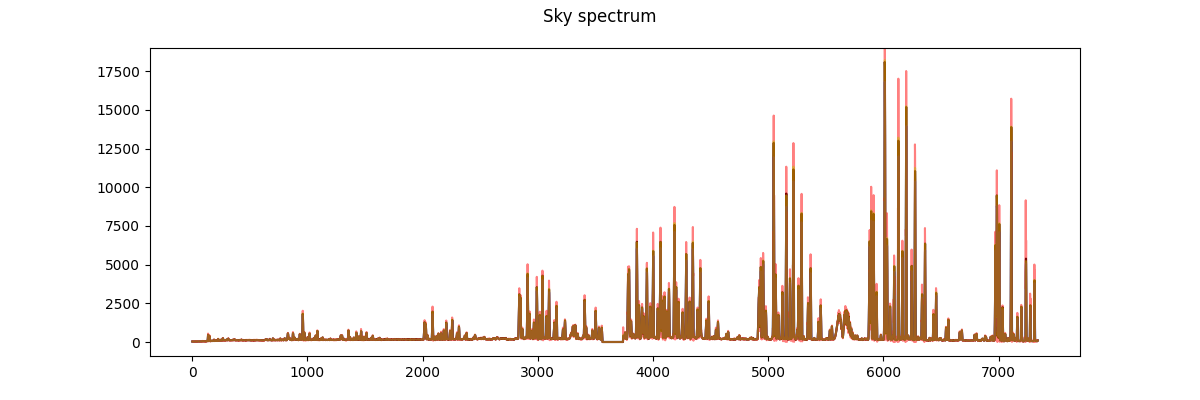

In [7]:
def richardson_lucy_iteration(data, previous_iteration, smoothing_radius):
    epsilon = 1e-3*np.min(data[data > 0])
    estimate = ndimage.gaussian_filter(previous_iteration, smoothing_radius)
    return previous_iteration * ndimage.gaussian_filter((data+epsilon) / (estimate+epsilon), smoothing_radius)


class Explore1D(object):
    
    def __init__(self, data, fig_name):
        """Interactive display"""
        
        self.data = np.where(np.isfinite(data), data, 0)
        self.percentiles = np.array([1, 16, 50, 84, 99])
        self.ticks = np.nanpercentile(data, self.percentiles)
        self.norm = colors.SymLogNorm(vmin=self.ticks[0], vmax=self.ticks[-1], linthresh=np.median(data[data > 0]))
        self.norm = colors.Normalize(vmin=100, vmax=self.ticks[-1])
        self.cmap = plt.get_cmap("gist_earth").copy()
        self.cmap.set_bad('gray')
        
        plt.close(fig_name)
        self.fig = plt.figure(fig_name, figsize=(12, 4))
        self.axes = self.fig.subplots(nrows=1, ncols=1, squeeze=False)
        self.fig.suptitle(fig_name)

        self.ax0 = self.axes[0, 0]
        #self.ax0.set_title('original')
        self.ax0.plot(self.data, 'k-')

        self.widget = widgets.interactive(self.update, smoothing_radius=widgets.IntSlider(min=1, max=100, continuous_update=False))
        display(self.widget)


    def update(self, smoothing_radius):
        xlim = self.ax0.get_xlim()
        ylim = self.ax0.get_ylim()
        self.ax0.clear()
        self.ax0.plot(self.data, 'k-')

        smooth_data = ndimage.gaussian_filter(self.data, smoothing_radius)
        self.ax0.plot(smooth_data, 'b-', alpha=.5)

        RL = np.ones_like(self.data)
        n_iter = 100
        for i in range(n_iter):
            #print(i, np.nansum(sky_RL))
            RL = richardson_lucy_iteration(self.data, RL, smoothing_radius)
        smooth_data = ndimage.gaussian_filter(RL, smoothing_radius)
        self.ax0.plot(RL, 'r-', alpha=.5)
        self.ax0.plot(smooth_data, 'y-', alpha=.5)

        self.ax0.set_xlim(xlim)
        self.ax0.set_ylim(ylim)
        self.fig.canvas.draw_idle()

if len(data.shape) == 1:
    x = Explore1D(data, object_name)

interactive(children=(IntSlider(value=1, continuous_update=False, description='n_iter', min=1), Output()), _do…

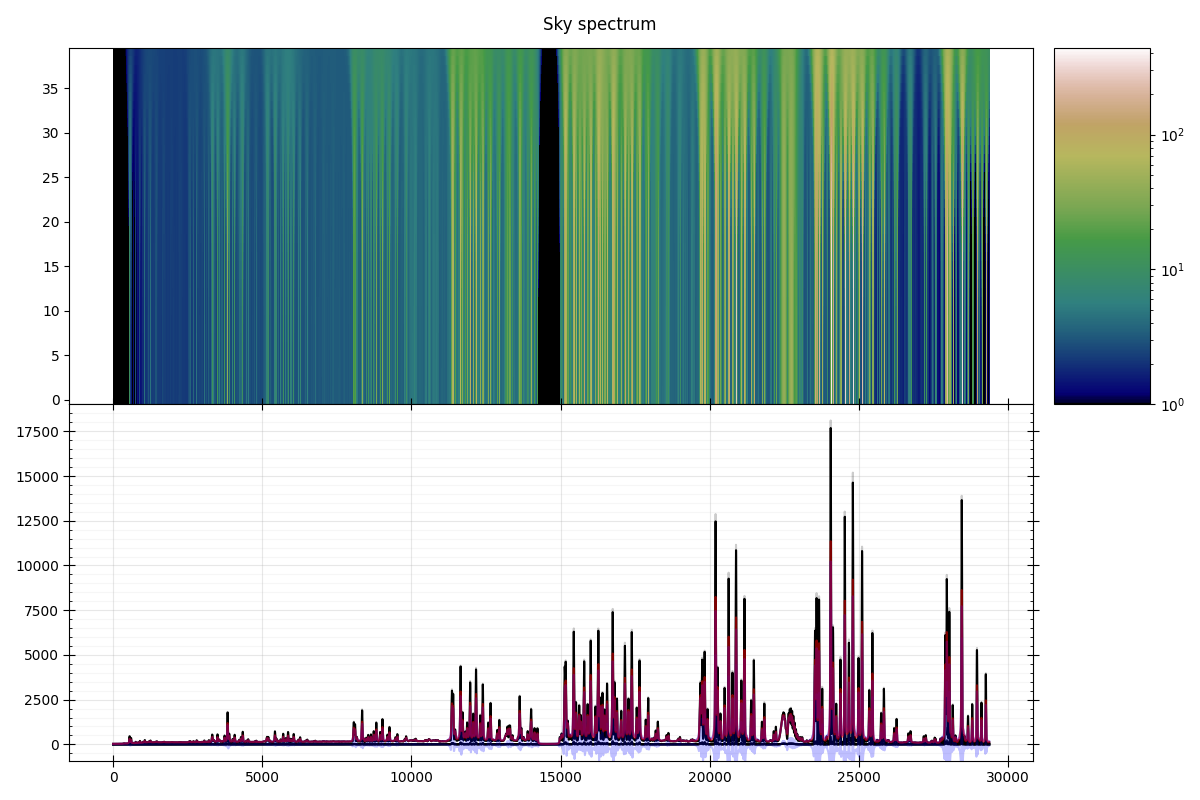

In [57]:
def GARLIC_iteration_1D(data, previous_iteration, smoothing_radii):
    """General-purpose Adaptive[Automatic/Analysis through] Richardson-Lucy Image Characterisation"""
    epsilon = 1e-3*np.min(data[data > 0])
    
    estimate = np.empty_like(previous_iteration)
    for i, radius in enumerate(smoothing_radii):
        estimate[i] = ndimage.gaussian_filter(previous_iteration[i], radius)
    estimate = np.sum(estimate, axis=0)

    new_iteration = previous_iteration
    for i, radius in enumerate(smoothing_radii):
         new_iteration[i] *= ndimage.gaussian_filter((data+epsilon) / (estimate+epsilon), radius)
    return new_iteration


class Explore1D(object):
    
    def __init__(self, data, fig_name, resolution_boost=4):
        """Interactive display"""
        
        '''
        self.fig, self.axes = new_figure(fig_name, figsize=(12, 8), nrows=2, ncols=2, sharex='col', sharey=False, gridspec_kw={'width_ratios': [1, .1]})
        '''
        plt.close(fig_name)
        self.fig = plt.figure(fig_name, figsize=(12, 8))
        self.axes = self.fig.subplots(nrows=2, ncols=2, squeeze=False, sharex='col', gridspec_kw={'width_ratios': [1, .1], 'hspace': 0})
        self.fig.suptitle(fig_name)
        self.fig.set_tight_layout(True)

        self.resolution_boost = resolution_boost
        self.original = data
        self.offset = np.nanmin(data)
        self.data = np.where(np.isfinite(data), data-self.offset, 0)
        self.data = np.interp(np.arange(self.data.size*resolution_boost), np.arange(self.data.size)*resolution_boost, self.data)
        self.data = ndimage.gaussian_filter(self.data, resolution_boost/2)
        self.percentiles = np.array([1, 16, 50, 84, 99])
        self.ticks = np.nanpercentile(data, self.percentiles)
        self.norm = colors.SymLogNorm(vmin=self.ticks[0], vmax=self.ticks[-1], linthresh=np.median(data[data > 0]))
        self.norm = colors.Normalize(vmin=100, vmax=self.ticks[-1])
        self.cmap = plt.get_cmap("gist_earth").copy()
        self.cmap.set_bad('gray')


        self.ax_im = self.axes[0, 0]
        self.ax_cb = self.axes[0, 1]
        self.axes[1, 1].axis('off')

        self.ax0 = self.axes[1, 0]
        #self.ax0.set_title('original')
        self.ax0.plot(np.arange(self.original.size)*resolution_boost, self.original, 'k-', alpha=.2)
        self.ax0.plot(self.data, 'k-')

        self.widget = widgets.interactive(self.update, n_iter=widgets.IntSlider(min=1, max=100, continuous_update=False))
        display(self.widget)


    def update(self, n_iter):
        xlim = self.ax0.get_xlim()
        ylim = self.ax0.get_ylim()
        
        self.ax0.clear()
        self.ax0.plot(np.arange(self.original.size)*self.resolution_boost, self.original, 'k-', alpha=.2)
        self.ax0.plot(self.data+self.offset, 'k-')

        smoothing_radii = np.logspace(0, 2, 40)
        self.RL = np.ones((smoothing_radii.size,) + self.data.shape)
        for i in range(n_iter):
            self.RL = GARLIC_iteration_1D(self.data, self.RL, smoothing_radii)

        self.estimate = np.empty_like(self.RL)
        for i, radius in enumerate(smoothing_radii):
            self.ax0.plot(self.RL[i], 'k-', alpha=.1)
            self.estimate[i] = ndimage.gaussian_filter(self.RL[i], radius)
        self.estimate = np.sum(self.estimate, axis=0)
        print(np.median(self.data-self.estimate), np.mean(self.data-self.estimate), np.std(self.data-self.estimate), np.std(self.RL))

        self.ax0.plot(self.estimate+self.offset, 'b-', alpha=.5)
        self.ax0.plot(self.data-self.estimate, 'b-', alpha=.25)
        self.ax0.plot(np.sum(self.RL, axis=0)+self.offset, 'r-', alpha=.5)
        ax = self.ax0
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        ax.tick_params(which='both', bottom=True, top=True, left=True, right=True)
        ax.tick_params(which='major', direction='inout', length=8, grid_alpha=.3)
        ax.tick_params(which='minor', direction='in', length=2, grid_alpha=.1)
        ax.grid(True, which='both')

        self.ax_im.clear()
        im = self.ax_im.imshow(self.RL, interpolation='nearest', origin='lower', cmap='gist_earth', norm=colors.LogNorm(vmin=1))
        self.ax_im.set_aspect('auto')
        cb = plt.colorbar(im, cax=self.ax_cb, orientation='vertical', shrink=.9)
        self.fig.canvas.draw_idle()
        
        self.ax0.set_xlim(xlim)
        self.ax0.set_ylim(ylim)


if len(data.shape) == 1:
    x = Explore1D(data, object_name)

In [116]:
resolution_boost = 4
n_radii = 100
smoothing_radii = np.logspace(np.log10(resolution_boost/2), np.log10(data.size*resolution_boost)/2, n_radii)
#def GARLIC(data, smoothing_radii, resolution_boost=4):
#    """General-purpose Adaptive Richardson-Lucy Image Characterisation"""

# remove NaN and negative values
offset = np.nanmin(data)
boosted_data = np.where(np.isfinite(data), data-offset, 0)
# boost resolution
boosted_data = np.interp(np.arange(data.size*resolution_boost), np.arange(data.size)*resolution_boost, boosted_data)
boosted_data = ndimage.gaussian_filter(boosted_data, resolution_boost/2)

epsilon = 1e-3*np.min(data[data > 0])
RL = np.ones((smoothing_radii.size,) + boosted_data.shape)
rms_residual = np.inf
while rms_residual > np.std(RL):

    estimate = np.empty_like(RL)
    for i, radius in enumerate(smoothing_radii):
        estimate[i] = ndimage.gaussian_filter(RL[i], radius)
    estimate = np.sum(estimate, axis=0)
    rms_residual = np.std(boosted_data - estimate)

    for i, radius in enumerate(smoothing_radii):
         RL[i] *= ndimage.gaussian_filter((boosted_data+epsilon) / (estimate+epsilon), radius)
    print(rms_residual, np.std(RL))

    cumulative_flux_fraction = np.cumsum(np.sum(RL, axis=1))
    smoothing_radii = 10**np.interp(np.linspace(cumulative_flux_fraction[0], cumulative_flux_fraction[-1], n_radii), cumulative_flux_fraction, np.log10(smoothing_radii))
    print(smoothing_radii)

#    return RL

1255.019328912757 9.247255196569377
[  2.           2.09196306   2.18815473   2.28876943   2.39401055
   2.50409083   2.61923276   2.73966909   2.86564327   2.99740993
   3.13523543   3.27939836   3.43019011   3.58791551   3.75289336
   3.92545714   4.10595567   4.2947538    4.49223315   4.69879291
   4.91485061   5.14084296   5.37722679   5.62447991   5.88310211
   6.15361616   6.43656885   6.73253214   7.04210428   7.36591101
   7.70460688   8.0588765    8.42943598   8.81703436   9.2224551
   9.6465177   10.09007936  10.55403665  11.03932742  11.5469326
  12.07787824  12.63323757  13.21413318  13.82173926  14.45728399
  15.12205204  15.81738715  16.54469483  17.30544523  18.1011761
  18.93349589  19.80408703  20.71470927  21.66720332  22.66349451
  23.70559668  24.79561632  25.93575672  27.12832253  28.37572433
  29.68048359  31.04523767  32.47274523  33.96589178  35.52769549
  37.16131332  38.87004741  40.65735171  42.52683899  44.48228816
  46.52765188  48.66706456  50.9048507   53

In [117]:
t0 = time()
n_bins = max(int(np.sqrt(data.size)), 101)
percentiles = np.linspace(0, 100, n_bins)
percentile_values = np.nanpercentile(data, percentiles)

rho_x = (percentile_values[1:] + percentile_values[:-1]) / 2
rho = 1 / (percentile_values[1:] - percentile_values[:-1])
bad = np.where(~np.isfinite(rho))
rho[bad] = 0
i_mode = np.nanargmax(rho)
mode = percentile_values[i_mode]
mode_err = np.std(data[data < mode])

print(f"{n_bins} percentiles, mode = {mode:.3f} $\\pm$ {mode_err:.3f} ({time()-t0:.3g} s)")

101 percentiles, mode = 152.469 $\pm$ 31.600 (0.0019 s)


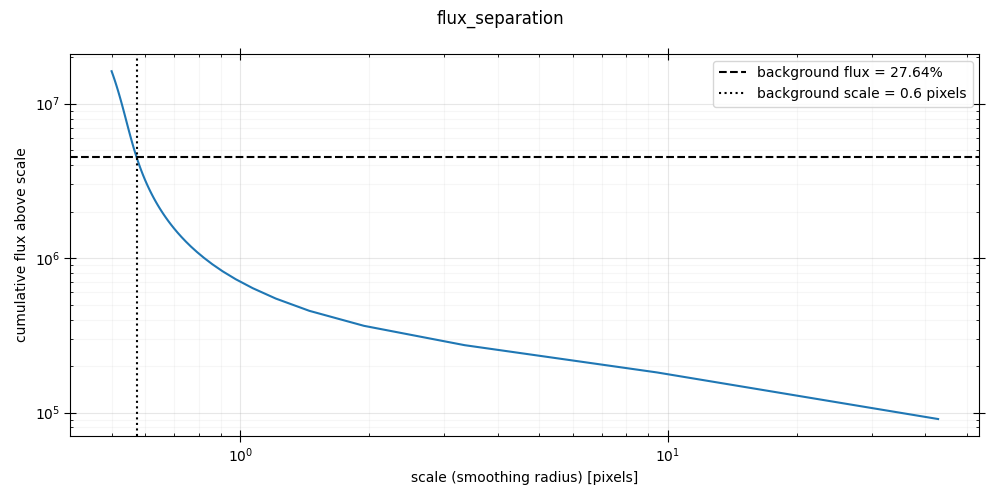

In [118]:
#total_weight = np.sum(RL)
cumulative_flux_above = np.cumsum(np.sum(RL, axis=1)[::-1])
background_flux = mode * boosted_data.size
background_scale = np.interp(background_flux, cumulative_flux_above, smoothing_radii[::-1])/resolution_boost

fig, axes = new_figure('flux_separation')

ax = axes[0,0]
ax.set_yscale('log')
ax.set_ylabel('cumulative flux above scale')
ax.set_xscale('log')
ax.set_xlabel('scale (smoothing radius) [pixels]')
ax.plot(smoothing_radii[::-1]/resolution_boost, cumulative_flux_above)
ax.axhline(background_flux, c='k', ls='--', label=f'background flux = {100*background_flux/np.sum(RL):.2f}%')
ax.axvline(background_scale, c='k', ls=':', label=f'background scale = {background_scale:.1f} pixels')
ax.legend()

plt.show()

> 8.305608349531598 16.766774124333125


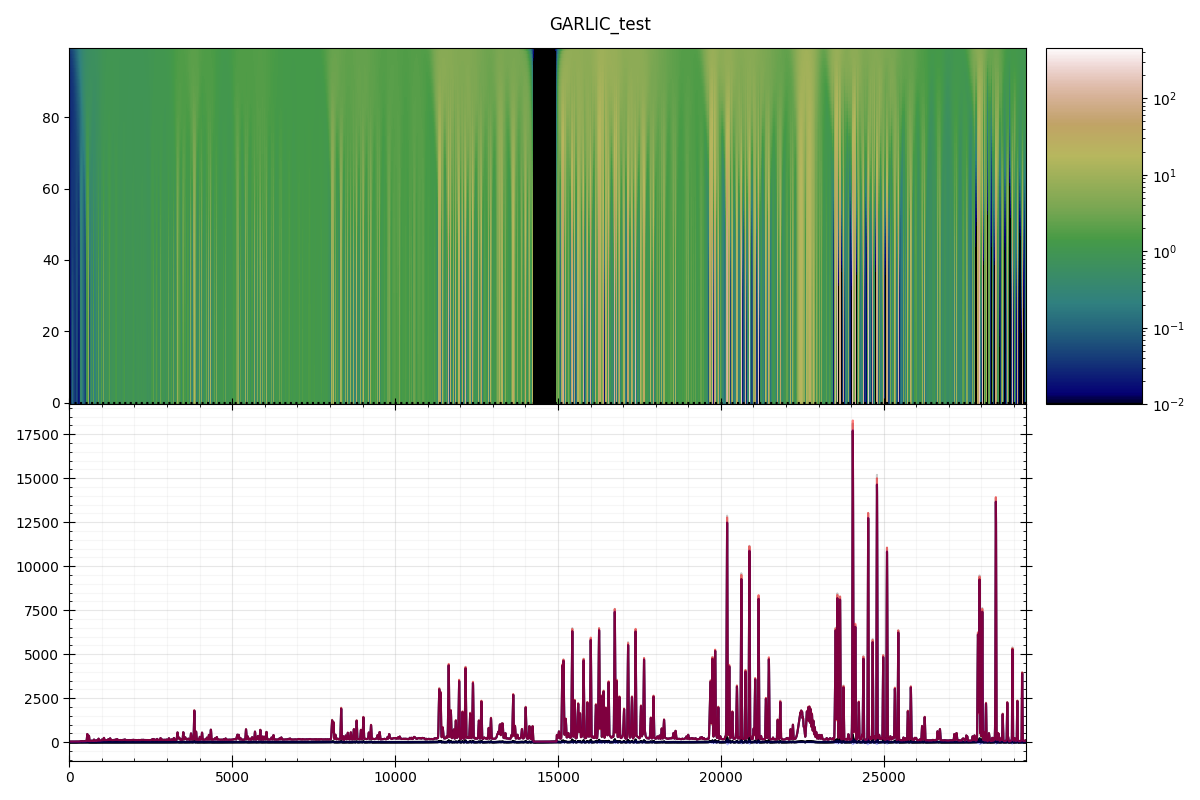

In [119]:
fig_name = 'GARLIC_test'
plt.close(fig_name)
fig = plt.figure(fig_name, figsize=(12, 8))
axes = fig.subplots(nrows=2, ncols=2, squeeze=False, sharex='col', gridspec_kw={'width_ratios': [1, .1], 'hspace': 0})
fig.suptitle(fig_name)
fig.set_tight_layout(True)


ax = axes[0, 0]
im = ax.imshow(RL, interpolation='nearest', origin='lower', cmap='gist_earth', norm=colors.LogNorm(vmin=1/n_radii))
ax.set_aspect('auto')
ax.axhline(np.interp(background_scale, smoothing_radii, np.arange(n_radii)), c='k', ls=':')

cb = plt.colorbar(im, cax=axes[0, 1], orientation='vertical', shrink=.9)


ax = axes[1, 0]
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='both', bottom=True, top=True, left=True, right=True)
ax.tick_params(which='major', direction='inout', length=8, grid_alpha=.3)
ax.tick_params(which='minor', direction='in', length=2, grid_alpha=.1)
ax.grid(True, which='both')

ax.plot(np.arange(data.size) * resolution_boost, data, 'k-', alpha=.2)
ax.plot(boosted_data + offset, 'k-')

estimate = np.empty_like(RL)
for i, radius in enumerate(smoothing_radii):
    ax.plot(RL[i], 'k-', alpha=.1)
    estimate[i] = ndimage.gaussian_filter(RL[i], radius)
estimate = np.sum(estimate, axis=0)
rms_residual = np.std(boosted_data - estimate)
print('>', rms_residual, np.std(RL))
ax.plot(estimate + offset, 'b-', alpha=.5)
ax.plot(boosted_data - estimate, 'b-', alpha=.25)
ax.plot(np.sum(RL, axis=0) + offset, 'r-', alpha=.5)


axes[1, 1].axis('off')
plt.show()

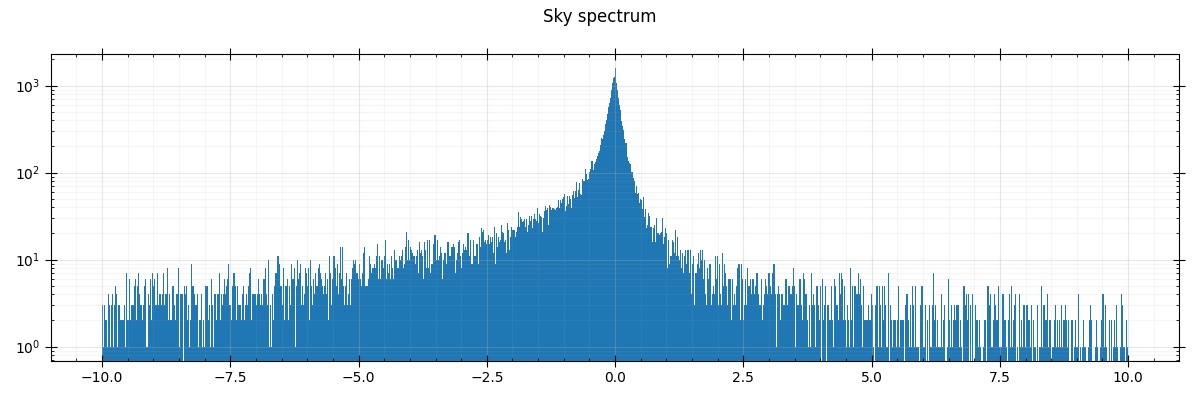

In [43]:
fig, axes = new_figure('hist', figsize=(12, 4))
ax = axes[0, 0]
ax.hist(x.estimate-x.data, bins=np.linspace(-10, 10, 1001))
ax.set_yscale('log')
plt.show()

In [9]:
smoothing_radii = np.logspace(0, 1, 2)
RL = np.ones((smoothing_radii.size,)+data.shape)
GARLIC_iteration_1D(data, RL, smoothing_radii), smoothing_radii

(array([[15.06019496, 15.11795627, 15.12560619, ..., 48.1500977 ,
         51.48311543, 52.66552915],
        [14.69941112, 14.70107113, 14.70437331, ..., 56.83828143,
         54.67528447, 53.60747667]]),
 array([ 1., 10.]))

# -- OLD STUFF --

# 2. Noise reduction

## Smoothing

In [10]:
n_smooth = 10
kernel_sizes = np.logspace(0, np.log10(data.size)/len(data.shape), n_smooth)
print(f'smoothing radius: {kernel_sizes}')

smoothing radius: [1.00000000e+00 2.68861340e+00 7.22864200e+00 1.94350237e+01
 5.22532651e+01 1.40488829e+02 3.77720146e+02 1.01554345e+03
 2.73040371e+03 7.34100000e+03]


In [11]:
smooth_data = np.empty((n_smooth,)+data.shape)
for i, radius in enumerate(kernel_sizes):
    smooth_data[i] = ndimage.gaussian_filter(np.where(np.isfinite(data), data, 0), radius)

## Background, noise, and significance estimates

In [12]:
'''
relative_tolerance = 1e-3
absolute_tolerance = 1e-30
def convergence(old, new):
    #print(old, new, (old - new)**2 <= relative_tolerance**2*(old**2 + new**2), ((old - new)**2 <= absolute_tolerance**2))
    return ((old - new)**2 <= relative_tolerance**2*(old**2 + new**2)) or ((old - new)**2 <= absolute_tolerance**2)


def find_background(x):
    old_mu = np.nanmean(x)
    old_var = np.nanvar(x)
    old_N0 = x.size
    p16, p50, p84 = np.nanpercentile(x.flat, [16, 50, 84])
    mu_w = p50
    var_w = min(p50-p16, p84-p50)**2
    N0 = x.size // 2

    while not (convergence(mu_w, old_mu)
               & convergence(var_w, old_var)
               & convergence(N0, old_N0)):
        weight = np.exp(-.5 * (x.flat-mu_w)**2 / var_w)
        total_weight = np.nansum(weight)
        mu = np.nansum(weight * x.flat) / total_weight
        var =  np.nansum(weight * (x.flat-mu)**2) / total_weight
        var0 = 1 / (1/var - 1/var_w)
        mu0 = var0 * (mu/var - mu_w/var_w)
        
        old_mu = mu_w
        old_var = var_w
        old_N0 = N0
        mu_w = mu0
        var_w = max(var0, absolute_tolerance)  # to prevent underflow
        N0 = np.count_nonzero(x < mu0)
        #print(mu0, var0, N0)

    print(f'{N0} values ({100*N0/x.size:.1f}%) below background = {mu0:.3e} +- {np.sqrt(var0):.3e} (median = {p50:.3e})')
    return mu0, np.sqrt(var0)


smooth_significance = np.zeros_like(smooth_data)
for i, radius in enumerate(kernel_sizes):
    bg, sigma_bg = find_background(smooth_data[i])
    smooth_significance[i] = (smooth_data[i] - bg) / sigma_bg

bg, sigma_bg = find_background(data)
significance = (data - bg) / sigma_bg
'''


"\nrelative_tolerance = 1e-3\nabsolute_tolerance = 1e-30\ndef convergence(old, new):\n    #print(old, new, (old - new)**2 <= relative_tolerance**2*(old**2 + new**2), ((old - new)**2 <= absolute_tolerance**2))\n    return ((old - new)**2 <= relative_tolerance**2*(old**2 + new**2)) or ((old - new)**2 <= absolute_tolerance**2)\n\n\ndef find_background(x):\n    old_mu = np.nanmean(x)\n    old_var = np.nanvar(x)\n    old_N0 = x.size\n    p16, p50, p84 = np.nanpercentile(x.flat, [16, 50, 84])\n    mu_w = p50\n    var_w = min(p50-p16, p84-p50)**2\n    N0 = x.size // 2\n\n    while not (convergence(mu_w, old_mu)\n               & convergence(var_w, old_var)\n               & convergence(N0, old_N0)):\n        weight = np.exp(-.5 * (x.flat-mu_w)**2 / var_w)\n        total_weight = np.nansum(weight)\n        mu = np.nansum(weight * x.flat) / total_weight\n        var =  np.nansum(weight * (x.flat-mu)**2) / total_weight\n        var0 = 1 / (1/var - 1/var_w)\n        mu0 = var0 * (mu/var - mu_w/va

In [13]:
def find_background(x, half_nbins=None):
    n_valid = np.count_nonzero(np.isfinite(x))
    if half_nbins is None:
        half_nbins = min(int(np.sqrt(n_valid)), 100)
    nbins = 2*half_nbins + 1  # make sure n_bins is odd

    percentile = np.linspace(100/n_valid, 100*(1-1/n_valid), nbins)
    percentile_value = np.nanpercentile(x, percentile)
    median = percentile_value[half_nbins]
    rho = 1 / (percentile_value[1:] - percentile_value[:-1])
    x_rho = (percentile_value[1:] + percentile_value[:-1]) / 2

    '''
    w = np.interp(x, x_rho, rho)
    total_weight = np.nansum(w)
    bg = np.nansum(w*x) / total_weight
    sigma_bg = np.sqrt(np.nansum(w*(x-bg)**2) / total_weight)
    '''
    w = rho**2
    total_weight = np.nansum(w)
    bg = np.nansum(w*x_rho) / total_weight
    sigma_bg = np.sqrt(np.nansum(w*(x_rho-bg)**2) / total_weight)

    return bg, sigma_bg


smooth_significance = np.zeros_like(smooth_data)
for i, radius in enumerate(kernel_sizes):
    bg, sigma_bg = find_background(smooth_data[i])
    smooth_significance[i] = (smooth_data[i] - bg).clip(min=0) / sigma_bg

bg, sigma_bg = find_background(data)
significance = (data - bg).clip(min=0) / sigma_bg


/tmp/ipykernel_23110/3789876784.py:10: RuntimeWarning: divide by zero encountered in true_divide
  rho = 1 / (percentile_value[1:] - percentile_value[:-1])
/tmp/ipykernel_23110/3789876784.py:21: RuntimeWarning: invalid value encountered in multiply
  bg = np.nansum(w*x_rho) / total_weight
/tmp/ipykernel_23110/3789876784.py:22: RuntimeWarning: invalid value encountered in multiply
  sigma_bg = np.sqrt(np.nansum(w*(x_rho-bg)**2) / total_weight)
/tmp/ipykernel_23110/3789876784.py:30: RuntimeWarning: divide by zero encountered in true_divide
  smooth_significance[i] = (smooth_data[i] - bg).clip(min=0) / sigma_bg
/tmp/ipykernel_23110/3789876784.py:30: RuntimeWarning: invalid value encountered in true_divide
  smooth_significance[i] = (smooth_data[i] - bg).clip(min=0) / sigma_bg


In [14]:
'''
mean_significance = significance.copy()
total_weight = np.zeros_like(mean_significance)


smooth_weight = np.zeros_like(smooth_data)  # To be removed

for i, radius in enumerate(kernel_sizes):
    weight = 2*data*smooth_data[i]/(data**2 + smooth_data[i]**2)
    weight[~np.isfinite(weight)] = 0
    weight = weight**2
    weight = ndimage.gaussian_filter(weight, radius)
    r0 = 10
    weight = radius/r0 * np.exp(-radius/r0)
    smooth_weight[i] = weight  # To be removed
    total_weight += weight
    mean_significance += weight * smooth_significance[i]
mean_significance /= total_weight
'''


'\nmean_significance = significance.copy()\ntotal_weight = np.zeros_like(mean_significance)\n\n\nsmooth_weight = np.zeros_like(smooth_data)  # To be removed\n\nfor i, radius in enumerate(kernel_sizes):\n    weight = 2*data*smooth_data[i]/(data**2 + smooth_data[i]**2)\n    weight[~np.isfinite(weight)] = 0\n    weight = weight**2\n    weight = ndimage.gaussian_filter(weight, radius)\n    r0 = 10\n    weight = radius/r0 * np.exp(-radius/r0)\n    smooth_weight[i] = weight  # To be removed\n    total_weight += weight\n    mean_significance += weight * smooth_significance[i]\nmean_significance /= total_weight\n'

In [15]:
'''
def find_excess(data, half_nbins=None):
    n_valid = np.count_nonzero(np.isfinite(data))
    if half_nbins is None:
        half_nbins = min(int(np.sqrt(n_valid)), 100)
    nbins = 2*half_nbins + 1  # make sure n_bins is odd

    percentile = np.linspace(100/n_valid, 100*(1-1/n_valid), nbins)
    percentile_value = np.nanpercentile(data, percentile)
    median = percentile_value[half_nbins]

    minimum_distance = np.fmin(median-percentile_value[:half_nbins], percentile_value[-1:half_nbins:-1]-median)
    symmetrised_value = np.concatenate([median-minimum_distance, [median], median+minimum_distance[::-1]])

    excess = (percentile_value-symmetrised_value)
    #norm = (median-symmetrised_value[0])
    norm = np.std(symmetrised_value)
    excess /= norm
    
    return np.interp(data, percentile_value, excess)


smooth_significance = np.zeros_like(smooth_data)
for i, radius in enumerate(kernel_sizes):
    smooth_significance[i] = find_excess(smooth_data[i])

significance = find_excess(data)
'''


'\ndef find_excess(data, half_nbins=None):\n    n_valid = np.count_nonzero(np.isfinite(data))\n    if half_nbins is None:\n        half_nbins = min(int(np.sqrt(n_valid)), 100)\n    nbins = 2*half_nbins + 1  # make sure n_bins is odd\n\n    percentile = np.linspace(100/n_valid, 100*(1-1/n_valid), nbins)\n    percentile_value = np.nanpercentile(data, percentile)\n    median = percentile_value[half_nbins]\n\n    minimum_distance = np.fmin(median-percentile_value[:half_nbins], percentile_value[-1:half_nbins:-1]-median)\n    symmetrised_value = np.concatenate([median-minimum_distance, [median], median+minimum_distance[::-1]])\n\n    excess = (percentile_value-symmetrised_value)\n    #norm = (median-symmetrised_value[0])\n    norm = np.std(symmetrised_value)\n    excess /= norm\n    \n    return np.interp(data, percentile_value, excess)\n\n\nsmooth_significance = np.zeros_like(smooth_data)\nfor i, radius in enumerate(kernel_sizes):\n    smooth_significance[i] = find_excess(smooth_data[i])\n\

In [16]:
'''
total_weight = find_excess(mean_significance)
mean_significance = significance * total_weight

smooth_weight = np.zeros_like(smooth_data)  # To be removed
for i, radius in enumerate(kernel_sizes):
    weight = 2*data*smooth_data[i]/(data**2 + smooth_data[i]**2)
    weight[~np.isfinite(weight)] = 0
    weight = ndimage.gaussian_filter(weight, radius/2)
    #weight = 1
    smooth_weight[i] = weight  # To be removed
    total_weight += weight
    mean_significance += weight * smooth_significance[i]
    #mean_significance += weight * smooth_significance[i]**3
    #mean_significance += weight * smooth_data[i]
#mean_significance = np.cbrt(mean_significance/total_weight)
mean_significance /= total_weight
'''


'\ntotal_weight = find_excess(mean_significance)\nmean_significance = significance * total_weight\n\nsmooth_weight = np.zeros_like(smooth_data)  # To be removed\nfor i, radius in enumerate(kernel_sizes):\n    weight = 2*data*smooth_data[i]/(data**2 + smooth_data[i]**2)\n    weight[~np.isfinite(weight)] = 0\n    weight = ndimage.gaussian_filter(weight, radius/2)\n    #weight = 1\n    smooth_weight[i] = weight  # To be removed\n    total_weight += weight\n    mean_significance += weight * smooth_significance[i]\n    #mean_significance += weight * smooth_significance[i]**3\n    #mean_significance += weight * smooth_data[i]\n#mean_significance = np.cbrt(mean_significance/total_weight)\nmean_significance /= total_weight\n'

In [17]:
#total_weight = 1-np.exp(-find_excess(significance).clip(min=0))
total_weight = 1
#total_weight = np.nanmean(significance[significance > 0]) / np.nanmean(-significance[significance < 0])
print(total_weight)
mean_significance = significance * total_weight

#smooth_weight = np.zeros_like(smooth_data)  # To be removed
for i, radius in enumerate(kernel_sizes):
    #weight = 1-np.exp(-find_excess(smooth_significance[i]).clip(min=0))
    #weight = radius*np.exp(-radius)
    weight = np.nanstd(smooth_significance[i]) / np.nanstd(significance)
    #weight = np.nanmean(smooth_significance[i][smooth_significance[i] > 0]) / np.nanmean(-smooth_significance[i][smooth_significance[i] < 0])
    #weight = 1
    #weight = 1
    #smooth_weight[i] = weight  # To be removed
    print(f'{radius:7.2f}, {weight:7.2f}')
    total_weight += weight
    mean_significance += weight * smooth_significance[i]
    #mean_significance += weight * smooth_significance[i]**3
    #mean_significance += weight * smooth_data[i]
#mean_significance = np.cbrt(mean_significance/total_weight)
mean_significance /= total_weight

1
   1.00,     nan
   2.69,     nan
   7.23,     nan
  19.44,    0.17
  52.25,    0.13
 140.49,    0.06
 377.72,    0.02
1015.54,    0.00
2730.40,    0.01
7341.00,    0.01


/home/yago/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1741: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe', where=where)


ERROR: data has 1 dimensions: (7341,)
ERROR: data has 1 dimensions: (7341,)
ERROR: data has 1 dimensions: (7341,)
ERROR: data has 1 dimensions: (7341,)
ERROR: data has 1 dimensions: (7341,)
ERROR: data has 1 dimensions: (7341,)
ERROR: data has 1 dimensions: (7341,)
ERROR: data has 1 dimensions: (7341,)
ERROR: data has 1 dimensions: (7341,)
ERROR: data has 1 dimensions: (7341,)
ERROR: data has 1 dimensions: (7341,)
ERROR: data has 1 dimensions: (7341,)
ERROR: data has 1 dimensions: (7341,)
ERROR: data has 1 dimensions: (7341,)
ERROR: data has 1 dimensions: (7341,)
ERROR: data has 1 dimensions: (7341,)
ERROR: data has 1 dimensions: (7341,)
ERROR: data has 1 dimensions: (7341,)
ERROR: data has 1 dimensions: (7341,)
ERROR: data has 1 dimensions: (7341,)
ERROR: data has 1 dimensions: (7341,)
ERROR: data has 1 dimensions: (7341,)


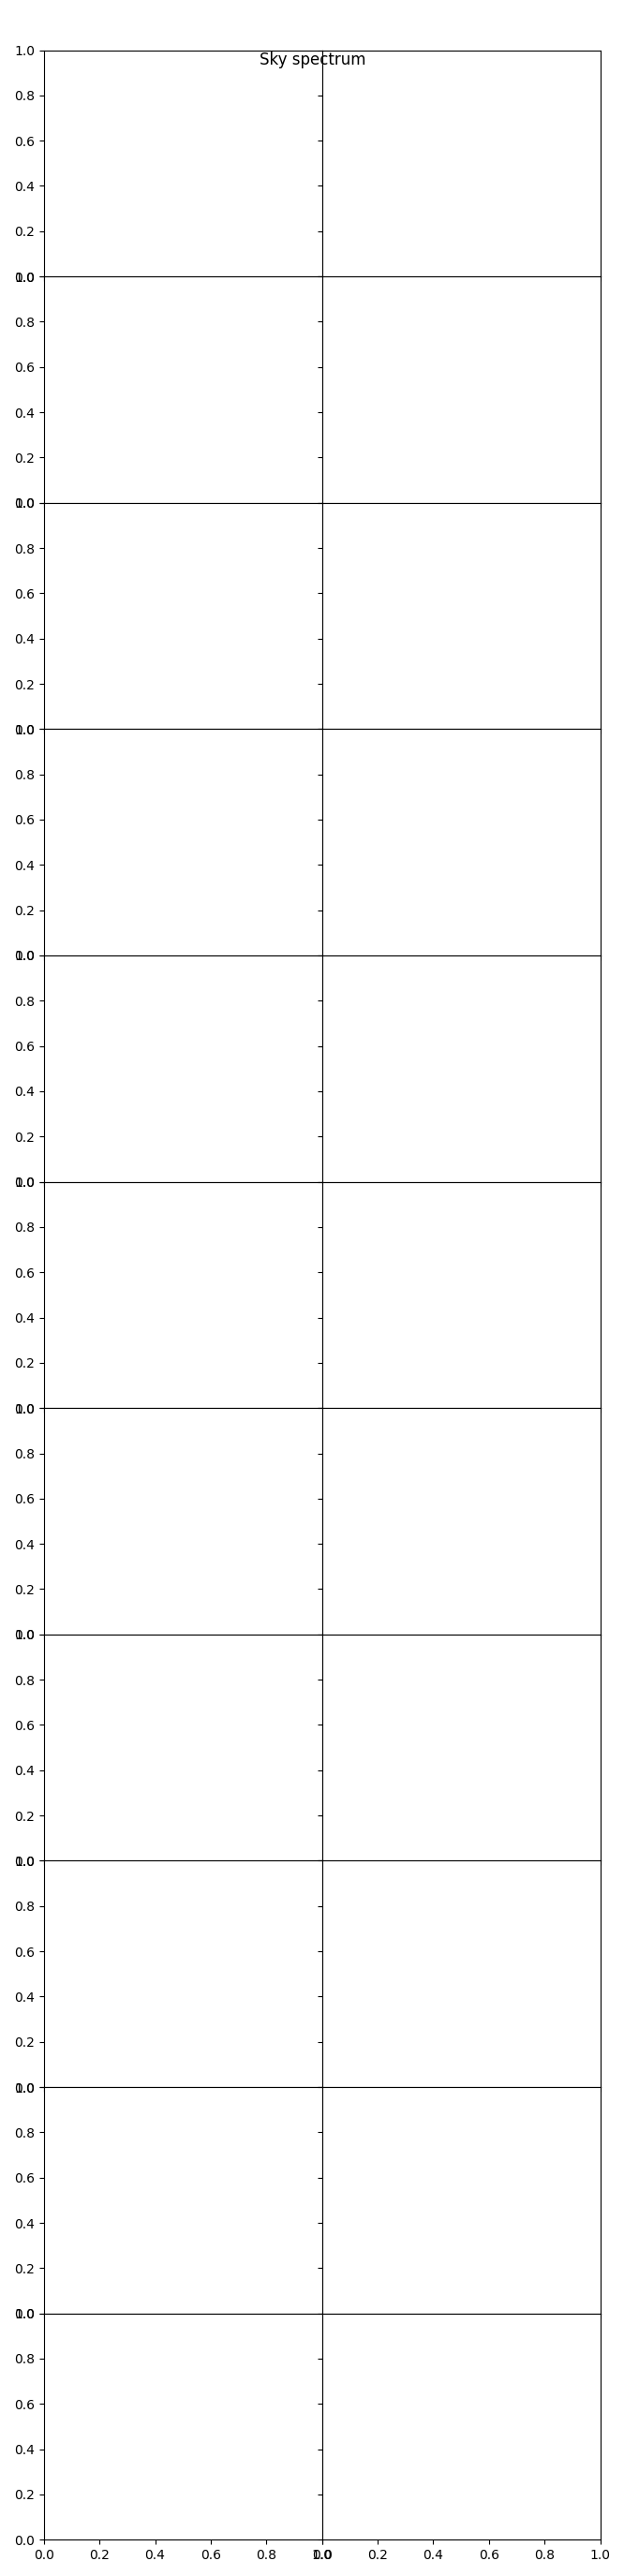

In [18]:
fig_name = 'visual_inspection'
plt.close(fig_name)

nrows = n_smooth+1
ncols = 2
panel_size = 2.5
cbar_fraction = .25

fig = plt.figure(fig_name, figsize=(ncols*panel_size/(1-cbar_fraction), nrows*panel_size))
axes = fig.subplots(nrows=nrows, ncols=ncols, squeeze=False,
                    sharex=True, sharey=True,
                    gridspec_kw={'hspace': 0, 'wspace': 0}
                   )
fig.set_tight_layout(True)
fig.suptitle(object_name)


def show_data(data, ax, cmap, norm):
    n_dim = len(data.shape)
    if n_dim == 2:
        intensity = data
    elif n_dim ==3:
        intensity = np.nanmean(data, axis=0)
        intensity = np.cbrt(np.nanmean(data**3, axis=0))
    else:
        print(f'ERROR: data has {n_dim} dimensions: {data.shape}')
        return
    
    im = ax.imshow(intensity,
                   interpolation='nearest', origin='lower',
                   cmap=cmap,
                   norm=norm,
                  )
    ax.set_aspect('auto')
    cb = fig.colorbar(im, ax=ax, orientation='vertical', shrink=.9, fraction=cbar_fraction)
    cb.ax.xaxis.label.set_size('small')


norm = colors.SymLogNorm(vmax=np.nanpercentile(data, 99), linthresh=np.nanmedian(data))
show_data(data, axes[0, 0], "gist_earth", norm)
for i in range(n_smooth):
    show_data(smooth_data[i], axes[i+1, 0], "gist_earth", norm)


norm = colors.SymLogNorm(vmin=0, vmax=1e3, linthresh=1)
#norm = colors.LogNorm()
#norm = colors.Normalize(vmin=-1, vmax=1)
show_data(significance, axes[0, 1], "gist_earth", norm)
for i in range(n_smooth):
    show_data(smooth_significance[i], axes[i+1, 1], "gist_earth", norm)

    
#pmin, p50, pmax = np.nanpercentile(intensity, [16, 50, 99])
#norm = colors.SymLogNorm(vmin=pmin, linthresh=2*p50-pmin, vmax=pmax)
#show_data(mean_significance, axes[0, 2], "gist_earth", norm)
#norm = colors.Normalize(vmin=0, vmax=1)
#for i in range(n_smooth):
#    show_data(smooth_weight[i], axes[i+1, 2], "rainbow", norm)

ERROR: data has 1 dimensions: (7341,)
ERROR: data has 1 dimensions: (7341,)


/home/yago/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1560: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,


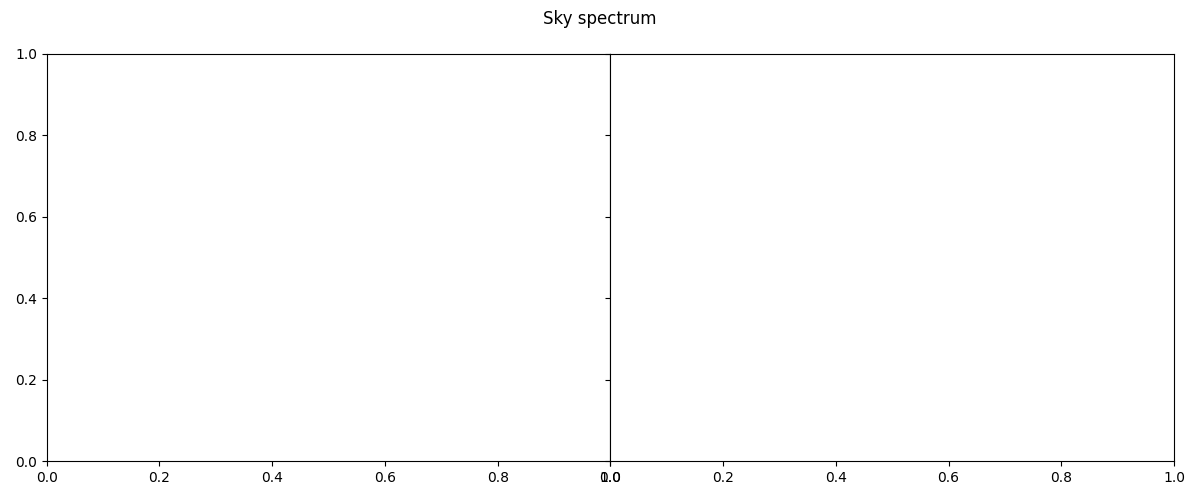

In [19]:
fig_name = 'mean_significance'
plt.close(fig_name)

ncols = 2
nrows = 1
panel_size = 5
cbar_size = 1
cbar_fraction = cbar_size/(panel_size+cbar_size)

fig = plt.figure(fig_name, figsize=(ncols*(panel_size+cbar_size), nrows*panel_size))
axes = fig.subplots(nrows=nrows, ncols=ncols, squeeze=False,
                    sharex=True, sharey=True,
                    gridspec_kw={'hspace': 0, 'wspace': 0}
                   )
fig.set_tight_layout(True)
fig.suptitle(object_name)


def show_data(data, ax, cmap, norm, levels):
    n_dim = len(data.shape)
    if n_dim == 2:
        intensity = data
    elif n_dim ==3:
        #intensity = np.nanmean(data, axis=0)
        #intensity = np.nanmax(data, axis=1)
        intensity = np.cbrt(np.nanmean((data-np.nanmean(data))**3, axis=0))
    else:
        print(f'ERROR: data has {n_dim} dimensions: {data.shape}')
        return
    
    im = ax.imshow(intensity,
                   interpolation='nearest', origin='lower',
                   cmap=cmap,
                   norm=norm,
                  )
    ax.set_aspect('auto')
#    bg, sigma_bg = find_background(intensity)
#    ax.contour(intensity, levels=bg+sigma_bg*np.array(levels), colors='black')
    cb = fig.colorbar(im, ax=ax, orientation='vertical', shrink=.9, fraction=cbar_fraction)
    cb.ax.xaxis.label.set_size('small')



p_min, p_lin, p_max = np.nanpercentile(data, [.01, 50, 99.9])
norm = colors.SymLogNorm(vmin=p_min, vmax=p_max, linthresh=p_lin)
show_data(data, axes[0, 0], "gist_earth", norm, [2, 3, 5, 10, 100])
#norm = colors.SymLogNorm(vmin=0, vmax=np.nanpercentile(mean_significance, 99.9), linthresh=np.nanmedian(mean_significance))
p_min, p_lin, p_max = np.nanpercentile(mean_significance, [.01, 50, 99.9])
norm = colors.SymLogNorm(vmin=p_min, vmax=p_max, linthresh=p_lin)
#norm = colors.Normalize(vmin=-.1, vmax=1)
show_data(mean_significance, axes[0, 1], "gist_earth", norm, [2, 3, 5, 10, 100])


## Sorting

In [20]:
importlib.reload(scripts.sort_data)
argsorted_data, n_valid = scripts.sort_data.run(mean_significance.ravel())

Sorted 0 finite measurements in ascending order (0.000237 s)


In [21]:
argsorted_data.size, np.count_nonzero(mean_significance > 0)

(0, 0)

# 3. Source finding

## Hierarchical Overdensity Tree (HOT)

In [22]:
importlib.reload(scripts.HOT)
sorted_strides = np.hstack([np.sort(data.strides)//data.itemsize, data.size]) # DIRTY HACK when testig particles at the boundary
t0 = time()
label, catalog = scripts.HOT.run(data, argsorted_data, sorted_strides)
print(f'     {time()-t0:.3g} seconds')

HOT: 0 overdensities found, 0 "pixels" (0%), 0 independent regions
     3.1 seconds


In [23]:
parent = catalog[0]
area = catalog[1]
test_stat = catalog[2]
#max_test_stat = catalog[3]

In [24]:
#cut = 1 + np.mean(mean_significance)
#cut = 30
cut = np.nansum(data)/data.size

In [25]:
fig_name = 'test_test_stat'
plt.close(fig_name)
fig = plt.figure(fig_name, figsize=(8, 4))
axes = fig.subplots(nrows=1, ncols=1, squeeze=False,
                    sharex=True, sharey='row',
                    gridspec_kw={'hspace': 0, 'wspace': 0})

ax = axes[0, 0]  # ----------------- new panel
'''
ax.scatter(area, test_stat, s=1, alpha=.1)
#ax.set_yscale('symlog')
ax.set_ylim(-100, 200)
#ax.set_xlim(-.1, 20)
ax.set_xscale('log')

n_sources = np.count_nonzero((test_stat > cut) & (area > cut))
ax.axhline(cut, c='k', ls='--', label=f'{np.count_nonzero(test_stat > cut)}')
ax.axvline(cut, c='k', ls=':', label=f'{n_sources}')
'''

ax.scatter(mean_significance.flat, data.flat, s=1, alpha=.05)
ax.set_xscale('log')
ax.set_yscale('log')

ax.legend(loc='upper right')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


ValueError: Data has no positive values, and therefore can not be log-scaled.

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous view', 'arrow-left', 'back'), ('Forward', 'Forward to next view', 'arrow-right', 'forward'), ('Pan', 'Left button pans, Right button zooms\nx/y fixes axis, CTRL fixes aspect', 'arrows', 'pan'), ('Zoom', 'Zoom to rectangle\nx/y fixes axis', 'square-o', 'zoom'), ('Download', 'Download plot', 'floppy-o', 'save_figure')]))

In [26]:
def show_parents(labels, parents, ax):
    for obj in np.unique(labels):
        if area[obj] > 10:
            y_obj, x_obj = np.unravel_index(np.nanargmax(np.where(label == obj, data, -np.inf)), data.shape)
            y_par, x_par = np.unravel_index(np.nanargmax(np.where(label == parents[obj], data, -np.inf)), data.shape)
            #print(f'{obj}, {parents[obj]}, {x_obj, y_obj}')
            ax.plot([x_obj, x_par], [y_obj, y_par], 'k+-', alpha=.5)

def show_segmentation(intensity, labels):
    fig_name = 'segmentation'
    plt.close(fig_name)
    fig = plt.figure(fig_name, figsize=(12, 8))
    
    axes = fig.subplots(nrows=2, ncols=2, squeeze=False,
                        sharex=True, sharey=True,
                        gridspec_kw={'hspace': 0, 'wspace': 0})

    ax = axes[0, 0]
    ax.set_title(object_name)
    im = ax.imshow(
        intensity,
        interpolation='nearest', origin='lower',
        #cmap='ocean',
        #cmap='nipy_spectral',
        #cmap='terrain',
        #cmap='magma',
        #cmap='gist_heat',
        cmap='gist_earth',
        #cmap='YlGn',
        norm=colors.SymLogNorm(linthresh=np.nanmedian(intensity)),
        )
    cb = fig.colorbar(im, ax=ax, shrink=.7)

    ax = axes[0, 1]
    ax.set_title('Significance')
    im = ax.imshow(
        mean_significance,
        interpolation='nearest', origin='lower',
        cmap='gist_earth',
        #vmax=1,
        norm=colors.SymLogNorm(linthresh=np.nanmedian(mean_significance)),
        )
    cb = fig.colorbar(im, ax=ax, shrink=.7)

    ax = axes[1, 0]
    ax.set_title(f'segmentation')
    im = ax.imshow(
        #labels == study_object,
        labels,
        interpolation='nearest', origin='lower',
        cmap=final_cmap, vmin=-0.5, vmax=n_sources-0.5,
        )
    cb = fig.colorbar(im, ax=ax, shrink=.7)
    #show_parents(labels, parent, ax)

    ax = axes[1, 1]
    ax.set_title(f'Test statistic')
    im = ax.imshow(
        test_stat[labels], #*area[labels],
        #np.where(labels == 8448, intensity, 0),
        interpolation='nearest', origin='lower',
        #cmap='nipy_spectral_r',
        #cmap='inferno_r',
        cmap='hot', vmin=cut/2, vmax=cut,
        #cmap='seismic_r', norm=colors.LogNorm(vmin=.1*cut, vmax=10*cut),
        )
    cb = fig.colorbar(im, ax=ax)

    for ax in axes.flatten():
        ax.tick_params(which='both', direction='in')
        ax.grid(alpha=.5)
    fig.set_tight_layout(True)
    plt.show()

In [27]:
data_dimensionality = sorted_strides.size-1
n_sources = np.unique(label).size
my_cmap = np.vstack([(np.argsort(np.random.random(n_sources))+1)/n_sources, (np.argsort(np.random.random(n_sources))+1)/n_sources, (np.argsort(np.random.random(n_sources))+1)/n_sources, np.ones(n_sources)]).T
my_cmap[0, :] = [0., 0., 0., 1.]
final_cmap = colors.ListedColormap(my_cmap)

if data_dimensionality == 2:
    show_segmentation(data, label)

elif data_dimensionality == 3:
    axis = 0
    intensity = np.nanmean(mean_significance, axis=axis)
    #intensity = np.nanmean(data**2, axis=1)
    #intensity = np.nanmax(data, axis=1)
    #intensity = np.cbrt(np.nanmean((mean_significance-np.nanmean(mean_significance))**3, axis=axis))
    pmin, p50, pmax = np.nanpercentile(intensity, [16, 50, 99])
    intensity_scale = colors.SymLogNorm(vmin=pmin, linthresh=2*p50-pmin, vmax=pmax)
    #intensity_scale = colors.Normalize(vmin=0, vmax=1)
    show_segmentation(intensity, np.nanmax(label, axis=axis), intensity_scale)


In [28]:
np.count_nonzero(label == 7838), area[7838], test_stat[7838]

IndexError: index 7838 is out of bounds for axis 0 with size 1

In [ ]:
x = data[label == 8448]
b = np.min(x)
np.sum(x), b, area[8448], x.size, np.sum(x)-b*x.size, test_stat[8448]

In [ ]:
fig_name = 'max_test_stat'
plt.close(fig_name)
fig = plt.figure(fig_name, figsize=(8, 4))
axes = fig.subplots(nrows=1, ncols=1, squeeze=False,
                    sharex=True, sharey='row',
                    gridspec_kw={'hspace': 0, 'wspace': 0})

ax = axes[0, 0]  # ----------------- new panel

sources = np.where(reliability > 0)
sc = ax.scatter(test_stat[sources], max_test_stat[sources]/test_stat[sources],
                marker='o', s=10, c=reliability[sources], cmap='nipy_spectral_r')

ax.set_yscale('log')
ax.set_xscale('log')

In [ ]:
top = np.where(parent == np.arange(parent.size))[0]
top

In [ ]:
def print_children(node, level, max_level=6, max_children=2):
    children = np.where(parent == node)[0]
    print(f'{level*"|"}--{node} : A={area[node]}, T={test_stat[node]:.2g}({max_test_stat[node]:.2g}) R={reliability[node]:.2g}, {children.size} children')# ({children[:max_children]})')
    decreasing_area = np.argsort(area[children])[::-1]
    if level < max_level:
        for child in children[decreasing_area][:max_children]:
            if child != node: #and reliability[child] > 0:
                print_children(child, level+1, max_level, max_children)

print_children(top[1], 0)


## Reliability

In [ ]:
importlib.reload(scripts.reliability)
reliability = scripts.reliability.run(max_test_stat, area, plots=True)

In [ ]:
importlib.reload(scripts.reliability)
reliability = scripts.reliability.run(test_stat, area, plots=True)

In [ ]:
true_overdensity = reliability > 0.43
n_sources = np.count_nonzero(true_overdensity)
print(f'{n_sources} potential sources found')

## Clean-up

In [ ]:
fig_name = 'explore_significance'
plt.close(fig_name)
fig = plt.figure(fig_name, figsize=(8, 8))

axes = fig.subplots(nrows=2, ncols=2, squeeze=False,
                    sharex='col', sharey='row',
                    gridspec_kw={'hspace': 0, 'wspace': 0})
fig.suptitle(object_name)


def plot_projection(data, projection_axis, ax, transpose=False):
    intensity = np.cbrt(np.nanmean(data**3, axis=projection_axis))
    #intensity = np.nanmean(data, axis=projection_axis)
    if transpose:
        intensity = intensity.T
    print(intensity.shape)
    pmin, p50, pmax = np.nanpercentile(intensity, [1, 50, 99.9])
    intensity_scale = colors.SymLogNorm(vmin=pmin, linthresh=2*p50-pmin, vmax=pmax)
    im = ax.imshow(
        intensity,
        interpolation='nearest', origin='lower',
        cmap='rainbow',
        vmin=-pmax, vmax=pmax,
        #norm=intensity_scale,
        )
    cb = fig.colorbar(im, ax=ax, shrink=.7)
    ax.set_aspect('auto')


plot_projection(mean_significance, 0, axes[1, 0])
plot_projection(mean_significance, 2, axes[1, 1], True)
plot_projection(mean_significance, 1, axes[0, 0])


for ax in axes.flatten():
    ax.tick_params(which='both', direction='in')
    ax.grid(alpha=.5)
fig.set_tight_layout(True)
plt.show()

In [ ]:
importlib.reload(scripts.cleanup)
label, old_label = scripts.cleanup.run(label, parent, area, true_overdensity, plots=True)

## Explore results

### Definitions

In [ ]:
plots = True
data_dimensionality = sorted_strides.size-1
#p0, p16, p50, p100 = np.nanpercentile(data, [0, 16, 50, 100])
#colour_scale = colors.SymLogNorm(vmin=p50-3*(p50-p16), linthresh= p50+3*(p50-p16), vmax=p100)
#data_min = data.ravel()[argsorted_data[0]]
#pivot = np.percentile(data[data > 0], 1)
#scale_min = data.ravel()[argsorted_data[int(argsorted_data.size*.01)]]
#pivot = data.ravel()[argsorted_data[int(argsorted_data.size*.5)]]  # median
#scale_max = data.ravel()[argsorted_data[int(argsorted_data.size*.99)]]
#scale_max = data.ravel()[argsorted_data[-1]]
#colour_scale = colors.SymLogNorm(vmin=scale_min, linthresh=2*pivot-scale_min, vmax=scale_max)
p0, p16, p50, p100 = np.nanpercentile(data, [0, 16, 50, 100])
colour_scale = colors.SymLogNorm(vmin=p16, linthresh=2*p50-p16, vmax=p100+p16)

#colour_scale = colors.LogNorm(vmin=p16, vmax=p100)

In [ ]:
n_sources = np.unique(label).size
my_cmap = np.vstack([(np.argsort(np.random.random(n_sources))+1)/n_sources, (np.argsort(np.random.random(n_sources))+1)/n_sources, (np.argsort(np.random.random(n_sources))+1)/n_sources, np.ones(n_sources)]).T
my_cmap[0, :] = [0., 0., 0., 1.]
final_cmap = colors.ListedColormap(my_cmap)

### Segmentation

In [ ]:
def show_parents(labels, parents, ax):
    for obj in np.unique(labels):
        if area[obj] > 10:
            y_obj, x_obj = np.unravel_index(np.nanargmax(np.where(label == obj, data, -np.inf)), data.shape)
            y_par, x_par = np.unravel_index(np.nanargmax(np.where(label == parents[obj], data, -np.inf)), data.shape)
            #print(f'{obj}, {parents[obj]}, {x_obj, y_obj}')
            ax.plot([x_obj, x_par], [y_obj, y_par], 'k+-', alpha=.5)

def show_segmentation(intensity, labels, intensity_scale):
    fig_name = 'segmentation'
    plt.close(fig_name)
    fig = plt.figure(fig_name, figsize=(12, 4))
    
    axes = fig.subplots(nrows=1, ncols=3, squeeze=False,
                        sharex=True, sharey=True,
                        gridspec_kw={'hspace': 0, 'wspace': 0})

    ax = axes[0, 0]
    ax.set_title(object_name)
    im = ax.imshow(
        intensity,
        interpolation='nearest', origin='lower',
        #cmap='ocean',
        #cmap='nipy_spectral',
        #cmap='terrain',
        #cmap='magma',
        #cmap='gist_heat',
        cmap='gist_earth',
        #cmap='YlGn',
        norm=intensity_scale,
        )
    cb = fig.colorbar(im, ax=ax, shrink=.7)

    ax = axes[0, 1]
    ax.set_title(f'segmentation ({n_sources} objects)')
    im = ax.imshow(
        #labels == study_object,
        labels,
        interpolation='nearest', origin='lower',
        cmap=final_cmap, vmin=-0.5, vmax=n_sources-0.5,
        )
    cb = fig.colorbar(im, ax=ax, shrink=.7)
    #show_parents(labels, parent, ax)

    '''
    ax = axes[0, 1]
    ax.set_title(object_name)
    im = ax.imshow(
        total_weight,
        interpolation='nearest', origin='lower',
        #cmap='ocean',
        #cmap='nipy_spectral',
        cmap='terrain',
        norm = intensity_scale,
        )
    cb = fig.colorbar(im, ax=ax)
    '''

    '''
    ax = axes[0, 2]
    ax.set_title(f'segmentation ({n_sources} objects)')
    im = ax.imshow(
        new_label,
        interpolation='nearest', origin='lower',
        cmap=final_cmap,
        )
    cb = fig.colorbar(im, ax=ax)
    '''

    '''
    ax = axes[0, 2]
    ax.set_title(f'Reliability')
    im = ax.imshow(
        reliability[old_label[labels]],
        interpolation='nearest', origin='lower',
        #cmap='nipy_spectral_r',
        #cmap='inferno_r',
        cmap='hot_r',
        #cmap='gist_heat',
        )
    cb = fig.colorbar(im, ax=ax)
    '''

    ax = axes[0, 2]
    ax.set_title(f'Test statistic')
    im = ax.imshow(
        test_stat[labels]*area[labels],
        interpolation='nearest', origin='lower',
        #cmap='nipy_spectral_r',
        #cmap='inferno_r',
        cmap='hot_r',
        norm=colors.LogNorm(vmin=1e-7, vmax=1e-3),
        )
    cb = fig.colorbar(im, ax=ax)

    for ax in axes.flatten():
        ax.tick_params(which='both', direction='in')
        ax.grid(alpha=.5)
    fig.set_tight_layout(True)
    plt.show()

In [ ]:
if plots and data_dimensionality == 2:
    show_segmentation(data, label, colour_scale)

elif plots and data_dimensionality == 3:
    axis = 0
    intensity = np.nanmean(mean_significance, axis=axis)
    #intensity = np.nanmean(data**2, axis=1)
    #intensity = np.nanmax(data, axis=1)
    #intensity = np.cbrt(np.nanmean((mean_significance-np.nanmean(mean_significance))**3, axis=axis))
    pmin, p50, pmax = np.nanpercentile(intensity, [16, 50, 99])
    intensity_scale = colors.SymLogNorm(vmin=pmin, linthresh=2*p50-pmin, vmax=pmax)
    #intensity_scale = colors.Normalize(vmin=0, vmax=1)
    show_segmentation(intensity, np.nanmax(label, axis=axis), intensity_scale)


In [ ]:
'''
'''
if plots and data_dimensionality == 3:

    mode = 0
    projection_axis = 0
    max_map = np.nanmax(label, axis=projection_axis)

    #boundary = np.zeros_like(max_map)
    #boundary[:, :-1][max_map[:, :-1] != max_map[:, 1:]] = 1
    #boundary[:-1, :][max_map[:-1, :] != max_map[1:, :]] = 1
    plt.close('filtered')
    fig = plt.figure('filtered', figsize=(8, 8))
    ax = fig.subplots(nrows=2, ncols=2, squeeze=False,
                      sharex=True, sharey=True,
                      gridspec_kw={'bottom': .01, 'left': .1, 'top': .99, 'right': .92,
                                   'hspace': .01, 'wspace': .1},
                      subplot_kw={'projection': wcs},
                     )
    for axis in ax.flatten():
        axis.tick_params(which='both', direction='in')
        axis.grid(alpha=.5)
    #fig.set_tight_layout(True)

    '''
    ax[0, 0].set_title('Input data (max)')
    im = ax[0, 0].imshow(
        np.nanmax(data, axis=0),
        interpolation='nearest', origin='lower', cmap='terrain',
        norm = colour_scale
    )
    '''
    ax[0, 0].set_title('Mean significance')
    im = ax[0, 0].imshow(
        np.nanmean(mean_significance, axis=projection_axis),
        interpolation='nearest', origin='lower', cmap='terrain',
        norm = colour_scale
        #norm = intensity_scale
    )
    #ax[0, 0].contour(boundary, levels=[.5], colors='k', linewidths=0.1)
    #ax[1, 0].contour(boundary, levels=[.5], colors='k', linewidths=0.1)
    #ax[1, 1].contour(boundary, levels=[.5], colors='k', linewidths=0.1)
    #ax[0, 0].contour(max_map, levels=np.arange(n_sources)+.5, colors='k', linewidths=0.1)
    #ax[1, 0].contour(max_map, levels=np.arange(n_sources)+.5, colors='k', linewidths=0.1)
    #ax[1, 1].contour(max_map, levels=np.arange(n_sources)+.5, colors='w', linewidths=0.1)
    cb = fig.colorbar(im, ax=ax[0, 0])
    cb.ax.axhline(0, c='k', ls=':')
    #cb.ax.axhline(data.threshold-mode, c='k', ls='--')
    
    ax[0, 1].set_title('Input data (rms)')
    im = ax[0, 1].imshow(
        #(np.sqrt(np.nanmean((data-mode)**2, axis=0)) + np.nanmax(data, axis=0))/2,
        np.nansum(data, axis=projection_axis)/np.sqrt(np.nanmean(data**2, axis=projection_axis)),
        vmin=0,
        interpolation='nearest', origin='lower', cmap='terrain',
        #norm = colors.SymLogNorm(vmin=-delta_th, linthresh=3*delta_th, vmax=np.max(data-mode)),
        #vmin=-delta/100, vmax=3*delta/10,
        #norm = colour_scale,
    )
    #ax[0, 1].contour(max_map, levels=[0.5])
    cb = fig.colorbar(im, ax=ax[0, 1])
    cb.ax.axhline(0, c='k', ls=':')
    #cb.ax.axhline(data.threshold-mode, c='k', ls='--')
    
    ax[1, 0].set_title(f'Final selection map (max)\n({n_sources} objects)')
    im = ax[1, 0].imshow(
        max_map,
        interpolation='nearest', origin='lower',
        cmap=final_cmap, vmin=-0.5, vmax=n_sources-0.5,
        )
    cb = fig.colorbar(im, ax=ax[1, 0])

    #ax[1, 1].set_title('<lbl^2> / <lbl>')
    im = ax[1, 1].imshow(
        reliability[old_label[max_map]],
        #np.nansum(final_labels**2, axis=0) / np.nansum(final_labels, axis=0),
        interpolation='nearest', origin='lower',
        cmap='nipy_spectral_r',
        #vmin=n_reliable/(n_sources+1), vmax=reliability_threshold,
        #cmap='rainbow_r',
        #vmin=1, vmax=n_final_labels-1,
        )
    cb = fig.colorbar(im, ax=ax[1, 1])


In [ ]:
if plots and data_dimensionality == 3:
    x_range = np.round(plt.figure('segmentation').get_axes()[0].get_xlim()).astype(int)
    y_range = np.round(plt.figure('segmentation').get_axes()[0].get_ylim()).astype(int)
    section = (data[:, y_range[0]:y_range[1], x_range[0]:x_range[1]]-mode)
    section_lables = label[:, y_range[0]:y_range[1], x_range[0]:x_range[1]]
    norm = (y_range[1] - y_range[0]) * (x_range[1] - x_range[0])
    section_labels = label[:, y_range[0]:y_range[1], x_range[0]:x_range[1]]
    unique_section_labels = np.unique(section_labels)

    vertical_slit = np.max(section_labels, axis=2).T
    horizontal_slit = np.max(section_labels, axis=1).T

    plt.close('spectrum')
    fig = plt.figure('spectrum', figsize=(8, 8))
    ax = fig.subplots(nrows=5, ncols=1, squeeze=False,
                      sharex=True, sharey=False,
                      gridspec_kw={'hspace': 0, 'wspace': 0}
                     )
    for axis in ax.flatten():
        axis.tick_params(which='both', direction='in')
        axis.grid(alpha=.5)
        
    fig.set_tight_layout(True)

    
    ax[0, 0].set_title(f'Mean spectra for x in {x_range}, y in {y_range}\n({unique_section_labels.size} objects)')
    im = ax[0, 0].imshow(
        vertical_slit,
        interpolation='nearest', origin='lower',
        #vmin=0, vmax=n_final_labels-1, cmap='rainbow',
        cmap=final_cmap, vmin=-0.5, vmax=n_sources-0.5,
        )
    ax[0, 0].set_aspect('auto')
    ax[0, 0].set_ylabel(r'$\Delta y$')


    im = ax[1, 0].imshow(np.nanmean(section, axis=2).T,
                         interpolation='nearest', origin='lower', cmap='terrain',
                         #norm=colour_scale,
                        )
    #ax[1, 0].contour(vertical_slit, levels=0)
    ax[1, 0].set_aspect('auto')
    ax[1, 0].set_ylabel(r'$\Delta y$')


    ax[2, 0].plot(np.nanmean(section, axis=(1, 2)), 'k-', lw=3, alpha=.25)
    ax[2, 0].set_ylabel('spectrum')
    '''
    '''
    for lbl in unique_section_labels[:10]:  # Dirty fix
        mask = np.zeros_like(section)
        mask[section_labels == lbl] = 1
        if lbl == 0:
            ls = ':'
        else:
            ls = '-'
        ax[2, 0].plot(np.nansum(section*mask, axis=(1, 2))/norm, alpha=.5, ls=ls, label=f'{lbl}')
    mean_error = 1/np.sqrt(section.shape[1]*section.shape[2])
    #ax[2, 0].axhline(delta_th*mean_error*bg_std, c='k', ls=':')
    #ax[2, 0].axhline(-delta_th*mean_error*bg_std, c='k', ls=':')
    ax[2, 0].legend()
    
    
    im = ax[3, 0].imshow(np.nanmean(section, axis=1).T,
        #(np.nanmax(section, axis=1) + np.sqrt(np.nanmean(section**2, axis=1))).T/2,
                         interpolation='nearest', origin='lower', cmap='terrain',
                         #vmin=0,
                         norm=colour_scale,
                        )
    #ax[3, 0].contour(horizontal_slit, levels=0)
    ax[3, 0].set_aspect('auto')
    ax[3, 0].set_ylabel(r'$\Delta x$')

    ax[4, 0].set_ylabel(r'$\Delta x$')
    im = ax[4, 0].imshow(
        horizontal_slit,
        interpolation='nearest', origin='lower',
        #vmin=0, vmax=n_final_labels-1, cmap='rainbow',
        cmap=final_cmap, vmin=-0.5, vmax=n_sources-0.5,
        )
    ax[4, 0].set_aspect('auto')
    ax[4, 0].set_ylabel(r'$\Delta x$')

    ax[-1, 0].set_xlabel('frequency / wavelength channel')


## Save FITS file

In [ ]:
hdu_out = fits.PrimaryHDU(final_labels)
hdu_out.writeto('output/HOT_labels.fits', overwrite=True)
'''
'''


In [ ]:
if data_dimensionality == 3:
    hdu_out = fits.PrimaryHDU(np.sum(final_labels, axis=0) / (np.count_nonzero(final_labels, axis=0) + 1e-30))
    hdu_out.writeto('output/HOT_mask.fits', overwrite=True)
'''
'''
